# Implementación Redes Neuronales

In [3]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as scs
from itertools import product  
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import tensorflow as tf
tf.random.set_seed(1)
from sklearn.preprocessing import MinMaxScaler
import math
import xgboost as xg
import json

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from itertools import product

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# from common.utils import load_data, mape

# plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## FUNCIONES

In [6]:
path_general='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/'
path_general

'C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/'

## Variables globales

In [7]:
# steps = 330
variable_inte = 'variacion_log' # retorno logaritmicos lo que se llama retornos continuos
fecha_inicio_test = '2022-07-01'
#path_grafico = 'C:/Users/lifes/Documents/5. MAESTRIA CIENCIA DE DATOS/TRABAJO DE GRADO/Notebook Tesis/Graficos tesis python/'
path_grafico='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/graficos/'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["figure.edgecolor"] = "gray"
# variable_inte = 'variacion%'

In [8]:
from sklearn.metrics import mean_absolute_error

In [9]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def mae(y_true, y_pred):
    return np.mean(np.abs((np.asarray(y_pred) - np.asarray(y_true))/ np.asarray(y_true)))

def rmse(targets, predictions):
    differences = np.asarray(predictions) - np.asarray(targets)                       
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)          
    return rmse_val    

In [10]:
#Función para construir la matriz del modelo supervisado
def serie_supervisada(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('y%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
# Función de predicción
def agregarNuevoValor(x_test,newVal):
    arr=[]
    for i in x_test[0][0][1:x_test.shape[2]]:
        arr.append(i)
    arr.append(newVal[0][0])
    arr=pd.DataFrame(arr).values
    arr=np.array([arr])
    arr=arr.reshape((arr.shape[0], 1, arr.shape[1]))
    x_test=arr
    return x_test

In [12]:
def rmse_rn(targets, predictions):
    differences = predictions - targets                     
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)          
    return rmse_val

### Data

In [13]:
data_series = pd.read_csv('MDT_data_tesis_new.csv', sep = '|')
data_series = data_series.drop(columns = 'Unnamed: 0')
data_series.head()

,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log
0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579
1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571
2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480
3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488
4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972


In [14]:
data_series['fecha']= pd.to_datetime(data_series['fecha'])
data_series['dia_semana']=data_series['fecha'].dt.day_name()

### Modelo

In [16]:
Input_features=10
dias_predecir=90

In [ ]:
########################################## Omiteeeeeee dese aquiiiii #####################################################3

In [82]:
info = data_series[(data_series['nemotecnico']=='BCOLOMBIA')]
tabla=info.copy()
serie = tabla[['fecha','nemotecnico','variacion_log']]
del tabla, info
#serie=data_series[(data_series['nemotecnico']==Accion)]
serie.set_index('fecha',inplace=True)
idx = pd.date_range(serie.index.min(), serie.index.max())
idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
serie=serie.reindex(idx, fill_value=0)
serie.reset_index(inplace=True)
serie.rename(columns={'index':'fecha'},inplace=True)
serie.drop(columns=['nemotecnico'],inplace=True)
serie.set_index('fecha',inplace=True)


values = serie['variacion_log'].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)
reframed = serie_supervisada(scaled, Input_features)
train_size= 661
#train_size=len(reframed)*0.8
values = reframed.values
train,test  = values[:int(train_size), :],values[int(train_size):, :]
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
tf.keras.optimizers.Adam(
learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
name='Adam'
)

In [63]:
info = data_series[(data_series['nemotecnico']=='BCOLOMBIA')]
tabla=info.copy()
serie = tabla[['fecha','nemotecnico','variacion_log']]
del tabla, info
#serie=data_series[(data_series['nemotecnico']==Accion)]
serie.set_index('fecha',inplace=True)
idx = pd.date_range(serie.index.min(), serie.index.max())
idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
serie=serie.reindex(idx, fill_value=0)
serie.reset_index(inplace=True)
serie.rename(columns={'index':'fecha'},inplace=True)
serie.drop(columns=['nemotecnico'],inplace=True)
serie.set_index('fecha',inplace=True)


values = serie['variacion_log'].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)
reframed = serie_supervisada(scaled, Input_features)

train_size=len(reframed)*0.8
train_size

868.0

In [64]:
values = reframed.values
train,test  = values[:int(train_size), :],values[int(train_size):, :]
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

In [ ]:
values = reframed.values
train,test  = values[:int(train_size), :],values[int(train_size):, :]
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

In [66]:
len(x_train)

868

In [67]:
len(x_test)

217

In [ ]:
values = reframed.values
train,test  = values[:int(train_size), :],values[int(train_size):, :]
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
tf.keras.optimizers.Adam(
learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
name='Adam'
)

In [71]:
df_final=data_series.copy()
df_final.head()

,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log,dia_semana
0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579,Wednesday
1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571,Thursday
2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480,Friday
3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488,Monday
4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972,Tuesday


In [72]:
timesteps=10

In [73]:
fecha_inicio_test

'2022-07-01'

In [74]:
scaler = MinMaxScaler()    
df_interes = df_final[df_final['nemotecnico']=='BCOLOMBIA'].reset_index()     


#### Train ###########
train = df_interes.copy()[(df_interes['fecha'] < fecha_inicio_test)]    
train = train[[variable_inte]]
train[variable_inte] = scaler.fit_transform(pd.DataFrame(train[variable_inte].tolist()))
train_data = train.values
#timesteps= parameters_list[j][0]
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]

#### test ###########
test = df_interes.copy()[(df_interes['fecha'] >= fecha_inicio_test)] 
test = test[[variable_inte]] 
test[variable_inte] = scaler.fit_transform(pd.DataFrame(test[variable_inte].tolist()))
test_data = test.values
test_data_timesteps = np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
print(str(timesteps)+ str(i))
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

In [75]:
len(x_train)

661

In [77]:
len(x_test)

54

In [78]:
Input_features

10

In [80]:
batch_size = 10

In [ ]:
model.add(LSTM(35,dropout=0.1,stateful=True, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(25,dropout=0.1))
model.add(Dropout(0.1))

In [ ]:
model.add(LSTM(90, ,input_shape=(1,Input_features)))
model.add(Dropout(0.1))

In [87]:
Input_features

10

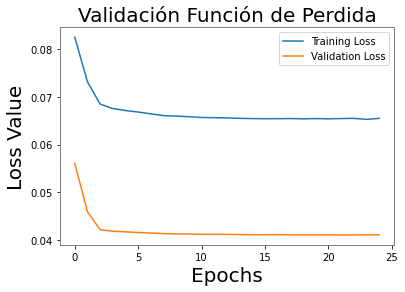

In [89]:
tf.keras.optimizers.Adam(
learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
name='Adam'
)

model=Sequential()
# model.add(Dense(Input_features,input_shape=(1,Input_features), activation='linear'))
# model.add(LSTM(90,dropout=0.1,stateful=True, return_sequences=True,batch_input_shape=4))
# model.add(Dense(1, activation='linear'))
model.add(LSTM(90,input_shape=(1,Input_features)))
model.add(Dropout(0.1))
model.compile(loss='mae',optimizer='Adam',metrics=['mse'])

#optimizer = keras.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
#'epochs':1000,
params={'epochs':500,
'batch_size':15,
'validation_split':0.1,
'shuffle':False, 'verbose':0,'seed':1234}

history=model.fit(x_train,y_train,
                 epochs=100,
                 batch_size=batch_size,
                 validation_split=0.1,
                 callbacks=[es],
                 shuffle=False, verbose=0)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Validación Función de Perdida', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss Value', fontsize=20)
plt.legend(fontsize=10)
plt.show()

In [101]:
x_test

array([[[-0.05091166, -0.05091166, -0.0457864 , ..., -0.05091166,
         -0.05091166,  0.05490871]],

       [[-0.05091166, -0.0457864 , -0.09896021, ..., -0.05091166,
          0.05490871, -0.06139003]],

       [[-0.0457864 , -0.09896021, -0.08900213, ...,  0.05490871,
         -0.06139003,  0.04430004]],

       ...,

       [[-0.05091166, -0.14591914, -0.07130717, ..., -0.05091166,
         -0.3737864 ,  0.14329208]],

       [[-0.14591914, -0.07130717,  0.10706668, ..., -0.3737864 ,
          0.14329208, -0.12187583]],

       [[-0.07130717,  0.10706668,  0.05253111, ...,  0.14329208,
         -0.12187583, -0.03420938]]], dtype=float32)

In [104]:
y_train.shape


(1, 661)

21/21 [==============================] - 0s 2ms/step
92.8204690138973
0.011819103592729311
0.011854055674059468
1/1 [==============================] - 0s 33ms/step


NameError: name 'Accion' is not defined

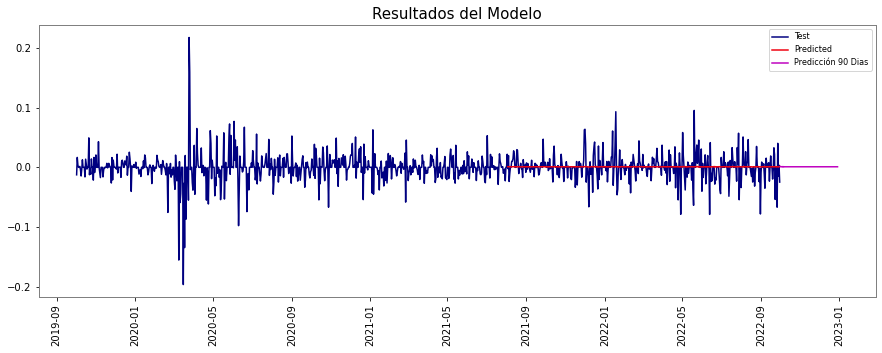

In [106]:
testPredict = model.predict(x_test)
testPredict=[a[0] for a in testPredict]
testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
trainPredict = model.predict(x_train)
trainPredict=[a[0] for a in trainPredict]
trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
serie.reset_index(inplace=True)

predicciones_train=pd.DataFrame(trainPredict[0])
valores_train=pd.DataFrame(y_train[0])
predicciones_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
valores_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)

predicciones_test=pd.DataFrame(testPredict[0])
valores_test=pd.DataFrame(y_test[0])
predicciones_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
valores_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
error_mape = mean_absolute_percentage_error(valores_test, predicciones_test)
print(error_mape)
error = mean_absolute_error(valores_test, predicciones_test) 
print(error)
error_rmse = rmse_rn(valores_test, predicciones_test)
print(error_rmse[0])

results=[]
incio=x_test[-1:]
for i in range(dias_predecir):
    parcial=model.predict(incio)
    parcial_=scaler.inverse_transform(parcial)
    results.append(parcial_[0])
    incio=agregarNuevoValor(incio,parcial)
result=pd.DataFrame(results)[0]

predicciones=pd.DataFrame(result)
predicciones.rename(columns={0:variable_inte},inplace=True)

plt.figure(figsize=(15,5))
plt.plot(idx.values,serie['variacion_log'],color='#000080', label='Serie Original')
plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],color = '#F0000F', label='Predicción Test')
#plt.plot(idx_[Input_features:len(x_train)+Input_features].values,trainPredict[0],c='y', label='Predicción Train')
plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
plt.xticks(rotation=90)
plt.legend(['Test','Predicted','Predicción 90 Dias'],loc=0, fontsize = 8)
plt.title('Resultados del Modelo', fontsize=15)
plt.title("Modelo RNN"+ ' '+ "Accion:" + ' '+ str(Accion), fontsize=15)
plt.xlabel('Días', fontsize=15)
plt.ylabel('Log Variacion Precio ', fontsize=15)
plt.show()

In [107]:
predicciones

,variacion_log
0,0.001393
1,0.000655
2,0.001052
3,0.001285
4,0.000454
...,...
85,0.000905
86,0.000905
87,0.000905
88,0.000905


In [92]:
testPredict

array([[-0.04578046, -0.04566094, -0.04598345, ..., -0.04582493,
        -0.04558644, -0.04560235],
       [-0.04609055, -0.04564237, -0.04591864, ..., -0.045797  ,
        -0.04553392, -0.04573871],
       [-0.046291  , -0.04582195, -0.04593966, ..., -0.04584061,
        -0.0457692 , -0.04609117],
       ...,
       [-0.04848692, -0.04651158, -0.04810993, ..., -0.04790333,
        -0.04678232, -0.04834998],
       [-0.04612012, -0.04551891, -0.04667849, ..., -0.04656046,
        -0.04561306, -0.04610634],
       [-0.044182  , -0.0453463 , -0.04488295, ..., -0.0441501 ,
        -0.0449292 , -0.04377399]], dtype=float32)

In [96]:
testPredict=[a[0] for a in testPredict]

In [94]:
testPredict[0][0]

-0.04578046

In [ ]:
########################################## Hasta aquiiiii #####################################################3

In [20]:
@interact_manual
def construccion_RN(Guardar_Result=True,limpiar_result=False,Accion=data_series['nemotecnico'].unique(),Input_features=(1,10,1),batch_size=(1,30,1),dias_predecir=(1,90,1)):


    info = data_series[(data_series['nemotecnico']==Accion)]
    tabla=info.copy()
    serie = tabla[['fecha','nemotecnico','variacion_log']]
    del tabla, info
    #serie=data_series[(data_series['nemotecnico']==Accion)]
    serie.set_index('fecha',inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
    serie=serie.reindex(idx, fill_value=0)
    serie.reset_index(inplace=True)
    serie.rename(columns={'index':'fecha'},inplace=True)
    serie.drop(columns=['nemotecnico'],inplace=True)
    serie.set_index('fecha',inplace=True)


    values = serie['variacion_log'].values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) 
    scaled = scaler.fit_transform(values)
    reframed = serie_supervisada(scaled, Input_features, 1)  
    train_size=len(reframed)*0.8
    values = reframed.values
    train,test  = values[:int(train_size), :],values[int(train_size):, :]
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
    
    model=Sequential()
    model.add(Dense(Input_features,input_shape=(1,Input_features), activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae',optimizer='Adam',metrics=['mse'])
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')

    params={'epochs':500,
    'batch_size':15,
    'validation_split':0.1,
    'shuffle':False, 'verbose':0,'seed':1234}
    
    history=model.fit(x_train,y_train,
                     epochs=500,
                     batch_size=batch_size,
                     validation_split=0.1,
                     callbacks=[es],
                     shuffle=False, verbose=0)
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Validación Función de Perdida', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss Value', fontsize=20)
    plt.legend(fontsize=10)
    plt.show()
    
    
    ### Guardando los modelos
    
    import pickle
    
    path_model='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/modelos/'

    file_name = path_model+ str(Accion)+'_model_rn.pkl'
    pickle.dump(model, open(file_name, "wb"))
    
    
    
    testPredict = model.predict(x_test)
    testPredict=[a[0][0] for a in testPredict]
    testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
    trainPredict = model.predict(x_train)
    trainPredict=[a[0][0] for a in trainPredict]
    trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])
    serie.reset_index(inplace=True)
    
    predicciones_train=pd.DataFrame(trainPredict[0])
    valores_train=pd.DataFrame(y_train[0])
    predicciones_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
    valores_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
    
    predicciones_test=pd.DataFrame(testPredict[0])
    valores_test=pd.DataFrame(y_test[0])
    predicciones_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    valores_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    error_mape = mean_absolute_percentage_error(valores_test, predicciones_test)
    print(error_mape)
    error = mean_absolute_error(valores_test, predicciones_test) 
    print(error)
    error_rmse = rmse_rn(valores_test, predicciones_test)
    print(error_rmse[0])
    
    results=[]
    incio=x_test[-1:]
    for i in range(dias_predecir):
        parcial=model.predict(incio)
        parcial_=scaler.inverse_transform(parcial[0])
        results.append(parcial_[0][0])
        incio=agregarNuevoValor(incio,parcial[0])
    result=pd.DataFrame(results)[0]
    
    predicciones=pd.DataFrame(result)
    predicciones.rename(columns={0:variable_inte},inplace=True)
    
    path_pronosticos='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos/'

    writer=pd.ExcelWriter(path_pronosticos + 'pronostico_rn_vf_' + str(Accion)+'.xlsx',engine='openpyxl')
    predicciones.to_excel(writer, sheet_name=f'{i}',index=False)
    writer.save()

    plt.figure(figsize=(15,5))
    plt.plot(idx.values,serie['variacion_log'],color='#000080', label='Serie Original')
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],color = '#F0000F', label='Predicción Test')
    #plt.plot(idx_[Input_features:len(x_train)+Input_features].values,trainPredict[0],c='y', label='Predicción Train')
    plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
    plt.xticks(rotation=90)
    plt.legend(['Test','Predicted','Predicción 90 Dias'],loc=0, fontsize = 8)
    plt.title('Resultados del Modelo', fontsize=15)
    plt.title("Modelo RNN"+ ' '+ "Accion:" + ' '+ str(Accion), fontsize=15)
    plt.xlabel('Días', fontsize=15)
    plt.ylabel('Log Variacion Precio ', fontsize=15)
    plt.savefig(path_grafico + 'grafico_comparacion_prediccion_rn_'+str(Accion)+'.jpg',facecolor='white')
    plt.show()
    

    if Guardar_Result == True:    
        dict_resul={'Serie':str(Accion),'Modelo':'Red Neuronal','RMSE':error_rmse[0],'MAE':error,'MAPE':error_mape,'PARAMETROS XGB':params}
        if limpiar_result == False:
            with open(path_general + 'resultados_RN.json', 'a') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()
        else:
            with open(path_general + 'resultados_RN.json', 'w') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()

interactive(children=(Checkbox(value=True, description='Guardar_Result'), Checkbox(value=False, description='l…

### Resultados

In [24]:
with open(path_general + 'resultados_RN.json') as json_file:
    data=json_file.readlines()
    data=[a.replace('\n','') for a in data]
    mae=[json.loads(a)['MAE'] for a in data]
    mape=[json.loads(a)['MAPE'] for a in data]
    rmse=[json.loads(a)['RMSE'] for a in data]
    params=[json.loads(a)['PARAMETROS XGB'] for a in data]
    serie=[json.loads(a)['Serie'] for a in data]
    modelo=[json.loads(a)['Modelo'] for a in data]
    info=pd.DataFrame (columns = ['Serie','Modelo','RMSE','MAE','MAPE','PARAMETROS'])
    info['Serie']=serie
    info['Modelo']=modelo
    info['RMSE']=rmse
    info['MAE']=mae
    info['MAPE']=mape
    info['PARAMETROS']=params
    info.set_index('PARAMETROS',inplace=True)
    tabla=info.groupby(['Serie','Modelo']).agg({'MAE':'min','RMSE':'min', 'MAPE':'min'}).sort_values(by=['Serie','Modelo'])
    tabla.head(25)

In [22]:
data

['{"Serie": "BCOLOMBIA", "Modelo": "Red Neuronal", "RMSE": 0.022479694222781267, "MAE": 0.01367472985407565, "MAPE": 73.0187311969979, "PARAMETROS XGB": {"epochs": 500, "batch_size": 15, "validation_split": 0.1, "shuffle": false, "verbose": 0, "seed": 1234}}',
 '{"Serie": "BCOLOMBIA", "Modelo": "Red Neuronal", "RMSE": 0.022515963482896945, "MAE": 0.013765673318974162, "MAPE": 82.75942186995512, "PARAMETROS XGB": {"epochs": 500, "batch_size": 15, "validation_split": 0.1, "shuffle": false, "verbose": 0, "seed": 1234}}']

In [25]:
info.reset_index(inplace=True)
print(info.shape)
info

(22, 6)


,PARAMETROS,Serie,Modelo,RMSE,MAE,MAPE
0,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",BCOLOMBIA,Red Neuronal,0.022480,0.013675,73.018731
1,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",BCOLOMBIA,Red Neuronal,0.022516,0.013766,82.759422
2,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",BOGOTA,Red Neuronal,0.028375,0.013494,90.338145
3,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",BVC,Red Neuronal,0.015183,0.007718,56.201338
4,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CELSIA,Red Neuronal,0.013777,0.008033,91.368515
5,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CEMARGOS,Red Neuronal,0.022701,0.013534,71.893847
6,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CLH,Red Neuronal,0.023886,0.009002,7871.356898
7,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CNEC,Red Neuronal,0.015970,0.009988,73.185988
8,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CORFICOLCF,Red Neuronal,0.017396,0.010435,97.076691
9,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",ECOPETROL,Red Neuronal,0.027681,0.016796,96.716430


In [30]:
info['timesteps']=10

In [31]:
info[1:]

,PARAMETROS,Serie,Modelo,RMSE,MAE,MAPE,timesteps
1,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",BCOLOMBIA,Red Neuronal,0.022516,0.013766,82.759422,10
2,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",BOGOTA,Red Neuronal,0.028375,0.013494,90.338145,10
3,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",BVC,Red Neuronal,0.015183,0.007718,56.201338,10
4,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CELSIA,Red Neuronal,0.013777,0.008033,91.368515,10
5,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CEMARGOS,Red Neuronal,0.022701,0.013534,71.893847,10
6,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CLH,Red Neuronal,0.023886,0.009002,7871.356898,10
7,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CNEC,Red Neuronal,0.015970,0.009988,73.185988,10
8,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",CORFICOLCF,Red Neuronal,0.017396,0.010435,97.076691,10
9,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",ECOPETROL,Red Neuronal,0.027681,0.016796,96.716430,10
10,"{'epochs': 500, 'batch_size': 15, 'validation_split': 0.1, 'shuffle': False, 'verbose': 0, 'seed': 1234}",EXITO,Red Neuronal,0.021630,0.010177,51.996107,10


In [28]:
info.columns

Index(['PARAMETROS', 'Serie', 'Modelo', 'RMSE', 'MAE', 'MAPE'], dtype='object')

In [29]:
info_1=info[['Serie', 'Modelo', 'RMSE', 'MAE']]

In [32]:
info.to_csv(path_general + 'parametro_RN.csv', sep='|')

In [37]:
info_1.shape

(22, 4)

In [33]:
info_1.head()

,Serie,Modelo,RMSE,MAE
0,BCOLOMBIA,Red Neuronal,0.022480,0.013675
1,BCOLOMBIA,Red Neuronal,0.022516,0.013766
2,BOGOTA,Red Neuronal,0.028375,0.013494
3,BVC,Red Neuronal,0.015183,0.007718
4,CELSIA,Red Neuronal,0.013777,0.008033


In [38]:
info_1[1:].to_csv(path_general+'metricas_model_RN.csv',sep='|')

### Leyendo los pronosticos para concatenarlos

In [39]:
import os
os.getcwd()

'C:\\Users\\USUARIO\\Downloads'

In [40]:
path = "C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos"
dir_list = os.listdir(path)

print("Archivos y Carpetas en'", path, "' :")
print('\n')
print(dir_list)


Archivos y Carpetas en' C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos ' :


['consolidado_pronosticos_xgb.xlsx', 'consolidado_pronosticos_xgb_1.xlsx', 'pronostico_rn_vf_BCOLOMBIA.xlsx', 'pronostico_rn_vf_BOGOTA.xlsx', 'pronostico_rn_vf_BVC.xlsx', 'pronostico_rn_vf_CELSIA.xlsx', 'pronostico_rn_vf_CEMARGOS.xlsx', 'pronostico_rn_vf_CLH.xlsx', 'pronostico_rn_vf_CNEC.xlsx', 'pronostico_rn_vf_CORFICOLCF.xlsx', 'pronostico_rn_vf_ECOPETROL.xlsx', 'pronostico_rn_vf_EXITO.xlsx', 'pronostico_rn_vf_GRUPOARGOS.xlsx', 'pronostico_rn_vf_GRUPOAVAL.xlsx', 'pronostico_rn_vf_GRUPOSURA.xlsx', 'pronostico_rn_vf_ISA.xlsx', 'pronostico_rn_vf_NUTRESA.xlsx', 'pronostico_rn_vf_PFAVAL.xlsx', 'pronostico_rn_vf_PFCEMARGOS.xlsx', 'pronostico_rn_vf_PFCORFICOL.xlsx', 'pronostico_rn_vf_PFDAVVNDA.xlsx', 'pronostico_rn_vf_PFGRUPOARG.xlsx', 'pronostico_rn_vf_PFGRUPSURA.xlsx', 'pronostico_xgb_BCOLOMBIA.xlsx', 'pronostico_xgb_BOGOTA.xlsx', 'pronostico_xgb_BVC.xl

In [43]:
dir_list=[x for x in dir_list if 'pronostico_rn' in x]
print('catidad de archivos asociados a las acciones fueron cargados:',len(dir_list[:-1]))
dir_list[:-1]

catidad de archivos asociados a las acciones fueron cargados: 21


['pronostico_rn_vf_BCOLOMBIA.xlsx',
 'pronostico_rn_vf_BOGOTA.xlsx',
 'pronostico_rn_vf_BVC.xlsx',
 'pronostico_rn_vf_CELSIA.xlsx',
 'pronostico_rn_vf_CEMARGOS.xlsx',
 'pronostico_rn_vf_CLH.xlsx',
 'pronostico_rn_vf_CNEC.xlsx',
 'pronostico_rn_vf_CORFICOLCF.xlsx',
 'pronostico_rn_vf_ECOPETROL.xlsx',
 'pronostico_rn_vf_EXITO.xlsx',
 'pronostico_rn_vf_GRUPOARGOS.xlsx',
 'pronostico_rn_vf_GRUPOAVAL.xlsx',
 'pronostico_rn_vf_GRUPOSURA.xlsx',
 'pronostico_rn_vf_ISA.xlsx',
 'pronostico_rn_vf_NUTRESA.xlsx',
 'pronostico_rn_vf_PFAVAL.xlsx',
 'pronostico_rn_vf_PFCEMARGOS.xlsx',
 'pronostico_rn_vf_PFCORFICOL.xlsx',
 'pronostico_rn_vf_PFDAVVNDA.xlsx',
 'pronostico_rn_vf_PFGRUPOARG.xlsx',
 'pronostico_rn_vf_PFGRUPSURA.xlsx']

In [48]:
str('pronostico_rn_vf_BCOLOMBIA.xlsx')[17:-5]

'BCOLOMBIA'

In [49]:
ejemplo=pd.read_excel('C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos/pronostico_rn_vf_BCOLOMBIA.xlsx')
print(ejemplo.shape)
ejemplo.head()

(90, 1)


,variacion_log
0,0.000686
1,0.000325
2,0.000471
3,0.001193
4,0.000481


In [50]:
base=[]

for i in dir_list[:-1]:
    temp_df = pd.read_excel(path + '/' + i)
    print(str(i)[17:-5])
    #temp_df['nemotecnico']=str(i)[18:-5]
    temp_df['nemotecnico']=str(i)[17:-5]
    #temp_df.rename(columns={0:'pronostico'},inplace=True)
    temp_df.rename(columns={'variacion_log':'pronostico'},inplace=True)
    temp_df=temp_df[['nemotecnico','pronostico']]
    print('Tamaño Base:',temp_df.shape)
    print('\n')
    base.append(temp_df)
    
df_pronostico = pd.concat(base)
print('Tamaño Base unida:', df_pronostico.shape)
df_pronostico.head()

BCOLOMBIA
Tamaño Base: (90, 2)


BOGOTA
Tamaño Base: (90, 2)


BVC
Tamaño Base: (90, 2)


CELSIA
Tamaño Base: (90, 2)


CEMARGOS
Tamaño Base: (90, 2)


CLH
Tamaño Base: (90, 2)


CNEC
Tamaño Base: (90, 2)


CORFICOLCF
Tamaño Base: (90, 2)


ECOPETROL
Tamaño Base: (90, 2)


EXITO
Tamaño Base: (90, 2)


GRUPOARGOS
Tamaño Base: (90, 2)


GRUPOAVAL
Tamaño Base: (90, 2)


GRUPOSURA
Tamaño Base: (90, 2)


ISA
Tamaño Base: (90, 2)


NUTRESA
Tamaño Base: (90, 2)


PFAVAL
Tamaño Base: (90, 2)


PFCEMARGOS
Tamaño Base: (90, 2)


PFCORFICOL
Tamaño Base: (90, 2)


PFDAVVNDA
Tamaño Base: (90, 2)


PFGRUPOARG
Tamaño Base: (90, 2)


PFGRUPSURA
Tamaño Base: (90, 2)


Tamaño Base unida: (1890, 2)


,nemotecnico,pronostico
0,BCOLOMBIA,0.000686
1,BCOLOMBIA,0.000325
2,BCOLOMBIA,0.000471
3,BCOLOMBIA,0.001193
4,BCOLOMBIA,0.000481


In [52]:
path_pronosticos='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos/'

In [53]:
df_pronostico.columns

Index(['nemotecnico', 'pronostico'], dtype='object')

In [54]:
df_pronostico.to_excel(path_pronosticos + 'consolidado_pronosticos_rn.xlsx',index=False)

### LECTURA DE MODELO .pkl

In [18]:
import pickle

path_model='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/modelos/PFDAVVNDA_model_rn.pkl'
with open(path_model, 'rb') as archivo:
    model= pickle.load(archivo)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:50:32         1399
metadata.json                                  2023-03-30 07:50:32           64
variables.h5                                   2023-03-30 07:50:32        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars


In [35]:
info = data_series[(data_series['nemotecnico']=='PFDAVVNDA')]

In [36]:
info.shape

(733, 11)

In [43]:
info = data_series[(data_series['nemotecnico']=='PFDAVVNDA')]
tabla=info.copy()
serie = tabla[['fecha','nemotecnico','variacion_log']]
del tabla, info
#serie=data_series[(data_series['nemotecnico']==Accion)]
serie.set_index('fecha',inplace=True)
print(serie.shape)
idx = pd.date_range(serie.index.min(), serie.index.max())
idx_ = pd.date_range(serie.index.min(), serie.index.max() + np.timedelta64(dias_predecir,'D'))
serie=serie.reindex(idx, fill_value=0)
serie.reset_index(inplace=True)
serie.rename(columns={'index':'fecha'},inplace=True)
serie.drop(columns=['nemotecnico'],inplace=True)
serie.set_index('fecha',inplace=True)
print(serie.shape)

values = serie['variacion_log'].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)
reframed = serie_supervisada(scaled, Input_features, 1)  
#train_size=len(reframed)*0.8
train_size=1003
values = reframed.values
train,test  = values[:int(train_size), :],values[int(train_size):, :]
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

(733, 2)
(1095, 1)


In [44]:
x_train.shape

(1003, 1, 10)

In [45]:
x_test.shape

(82, 1, 10)

In [46]:
testPredict = model.predict(x_test)
testPredict=[a[0][0] for a in testPredict]
testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
trainPredict = model.predict(x_train)
trainPredict=[a[0][0] for a in trainPredict]
trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])
serie.reset_index(inplace=True)

predicciones_train=pd.DataFrame(trainPredict[0])
valores_train=pd.DataFrame(y_train[0])
predicciones_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
valores_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)

32/32 [==============================] - 0s 2ms/step


In [47]:
predicciones_test=pd.DataFrame(testPredict[0])
valores_test=pd.DataFrame(y_test[0])
predicciones_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
valores_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
error_mape = mean_absolute_percentage_error(valores_test, predicciones_test)
print(error_mape)
error = mean_absolute_error(valores_test, predicciones_test) 
print(error)
error_rmse = rmse_rn(valores_test, predicciones_test)
print(error_rmse[0])

results=[]
incio=x_test[-1:]
for i in range(dias_predecir):
    parcial=model.predict(incio)
    parcial_=scaler.inverse_transform(parcial[0])
    results.append(parcial_[0][0])
    incio=agregarNuevoValor(incio,parcial[0])
result=pd.DataFrame(results)[0]

predicciones=pd.DataFrame(result)
predicciones.rename(columns={0:variable_inte},inplace=True)


82.73074947227627
0.01028529529877057
0.016891706632231964
1/1 [==============================] - 0s 23ms/step


In [48]:
Accion='PFDAVVNDA'

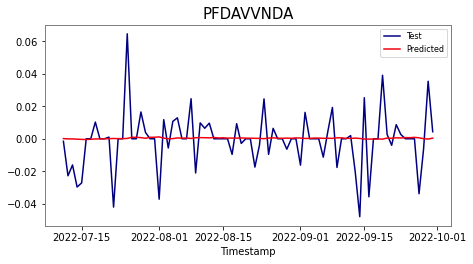

In [54]:
plt.figure(figsize=(7.28, 3.7 ))
plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,serie['variacion_log'][-82:],color='#000080', label='Serie Original')
plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],color = '#F0000F', label='Predicción Test')
#plt.plot(idx_[Input_features:len(x_train)+Input_features].values,trainPredict[0],c='y', label='Predicción Train')
#plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
plt.xticks(rotation=0)
plt.legend(['Test','Predicted'],loc=0, fontsize = 8)
plt.title('Resultados del Modelo', fontsize=15)
plt.title(str(Accion), fontsize=15)
plt.xlabel('Timestamp')
plt.savefig(path_grafico + 'grafico_comparacion_test_train_rn_'+str(Accion)+'.jpg',facecolor='white')
plt.show()
    



### Unificando

In [55]:
import pickle

In [57]:
Accion=data_series['nemotecnico'].unique()
Accion=list(Accion)
Accion

['BCOLOMBIA',
 'BOGOTA',
 'BVC',
 'CELSIA',
 'CEMARGOS',
 'CLH',
 'CNEC',
 'CORFICOLCF',
 'ECOPETROL',
 'EXITO',
 'GRUPOARGOS',
 'GRUPOAVAL',
 'GRUPOSURA',
 'ISA',
 'NUTRESA',
 'PFAVAL',
 'PFCEMARGOS',
 'PFCORFICOL',
 'PFDAVVNDA',
 'PFGRUPOARG',
 'PFGRUPSURA']

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:24:16         1395
metadata.json                                  2023-03-30 07:24:16           64
variables.h5                                   2023-03-30 07:24:16        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 2ms/step
78.23112305435
0.014702800335392058
0.023180117951677258
1/1 [==============================] - 0s 28ms/step
Imprimir grafico train-test


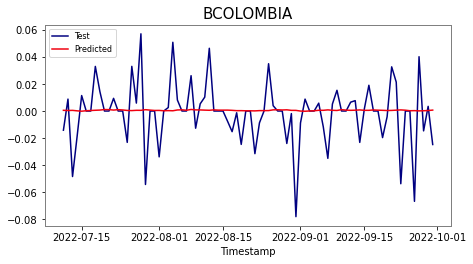

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:29:54         1395
metadata.json                                  2023-03-30 07:29:54           64
variables.h5                                   2023-03-30 07:29:54        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
77.8437140055022
0.01367105306521815
0.022759406728592935
1/1 [==============================] - 0s 23ms/step
Imprimir grafico train-test


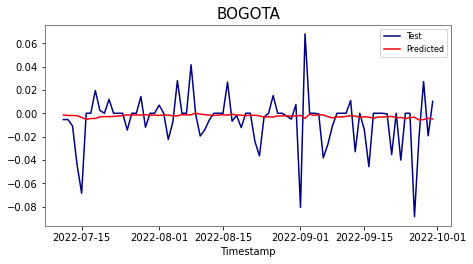

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:37:34         1395
metadata.json                                  2023-03-30 07:37:34           64
variables.h5                                   2023-03-30 07:37:34        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
48.7598611009985
0.008944690207135906
0.017757926878280296
1/1 [==============================] - 0s 27ms/step
Imprimir grafico train-test


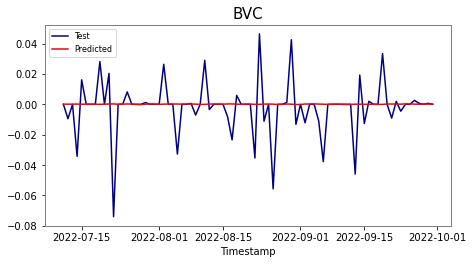

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:37:50         1398
metadata.json                                  2023-03-30 07:37:50           64
variables.h5                                   2023-03-30 07:37:50        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
86.51552395144816
0.009883402097425744
0.016469786754730358
1/1 [==============================] - 0s 23ms/step
Imprimir grafico train-test


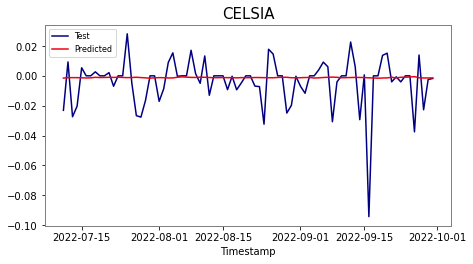

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:38:40         1398
metadata.json                                  2023-03-30 07:38:40           64
variables.h5                                   2023-03-30 07:38:40        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
76.45632779664545
0.01497587528411897
0.024633859456566702
1/1 [==============================] - 0s 58ms/step
Imprimir grafico train-test


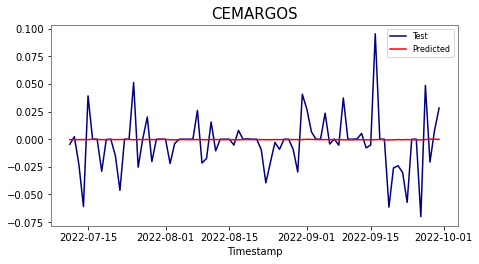

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:39:22         1398
metadata.json                                  2023-03-30 07:39:22           64
variables.h5                                   2023-03-30 07:39:22        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
283.57324360261214
0.007492740477265585
0.025401478206624997
1/1 [==============================] - 0s 23ms/step
Imprimir grafico train-test


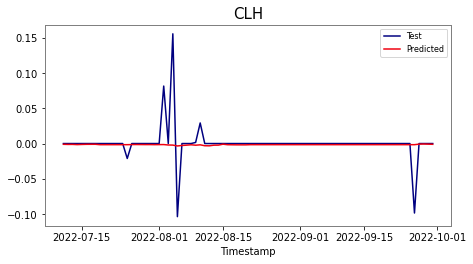

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:39:54         1398
metadata.json                                  2023-03-30 07:39:54           64
variables.h5                                   2023-03-30 07:39:54        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 4ms/step
72.56422155984946
0.011748177213187015
0.018209286449733988
1/1 [==============================] - 0s 22ms/step
Imprimir grafico train-test


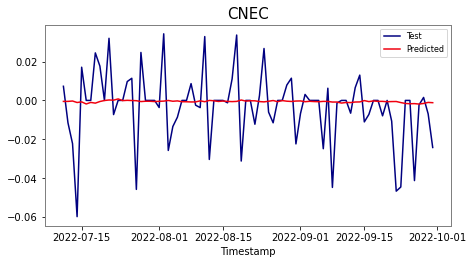

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:43:16         1398
metadata.json                                  2023-03-30 07:43:16           64
variables.h5                                   2023-03-30 07:43:16        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 2ms/step
105.2431857738038
0.013497661199629685
0.020082326683277616
1/1 [==============================] - 0s 24ms/step
Imprimir grafico train-test


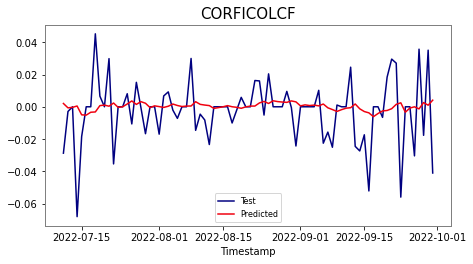

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:43:42         1399
metadata.json                                  2023-03-30 07:43:42           64
variables.h5                                   2023-03-30 07:43:42        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 2ms/step
106.47894576036774
0.01581139843704418
0.023437330557905388
1/1 [==============================] - 0s 24ms/step
Imprimir grafico train-test


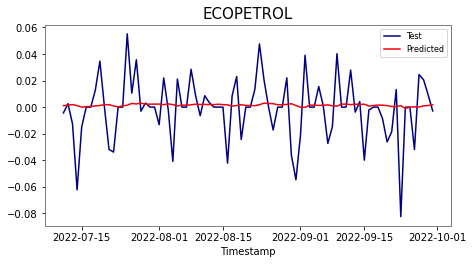

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:44:04         1399
metadata.json                                  2023-03-30 07:44:04           64
variables.h5                                   2023-03-30 07:44:04        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
54.498411985579885
0.009486971322527142
0.019424948181263047
1/1 [==============================] - 0s 37ms/step
Imprimir grafico train-test


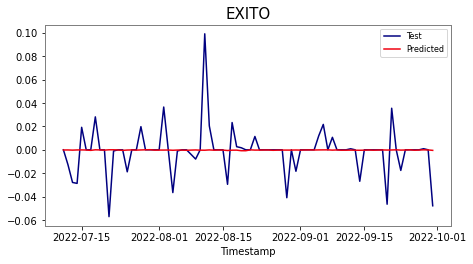

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:44:38         1399
metadata.json                                  2023-03-30 07:44:38           64
variables.h5                                   2023-03-30 07:44:38        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 2ms/step
81.65232014110404
0.016053845293906664
0.024408184756863256
1/1 [==============================] - 0s 38ms/step
Imprimir grafico train-test


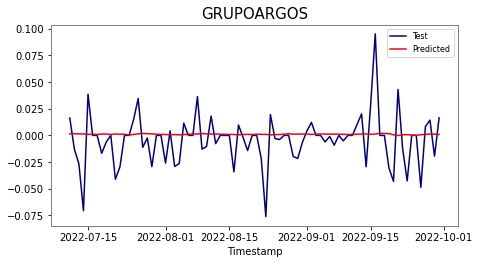

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:44:54         1399
metadata.json                                  2023-03-30 07:44:54           64
variables.h5                                   2023-03-30 07:44:54        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
54.857636023706476
0.006398126267402547
0.014738222173882142
1/1 [==============================] - 0s 23ms/step
Imprimir grafico train-test


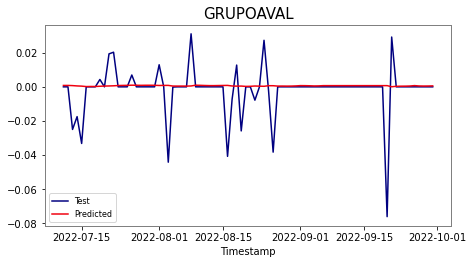

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:46:38         1399
metadata.json                                  2023-03-30 07:46:38           64
variables.h5                                   2023-03-30 07:46:38        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 2ms/step
97.5836061446867
0.014056553251211544
0.02232696714635206
1/1 [==============================] - 0s 25ms/step
Imprimir grafico train-test


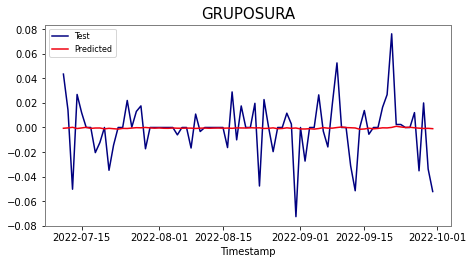

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:46:56         1399
metadata.json                                  2023-03-30 07:46:56           64
variables.h5                                   2023-03-30 07:46:56        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
75.411429057557
0.014167041946211776
0.021719220313409858
1/1 [==============================] - 0s 29ms/step
Imprimir grafico train-test


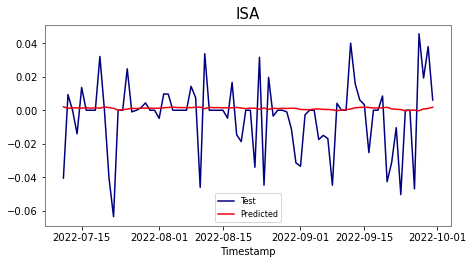

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:47:28         1399
metadata.json                                  2023-03-30 07:47:28           64
variables.h5                                   2023-03-30 07:47:28        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 2ms/step
102.59314374959807
0.01164278254616006
0.01959282318556461
1/1 [==============================] - 0s 24ms/step
Imprimir grafico train-test


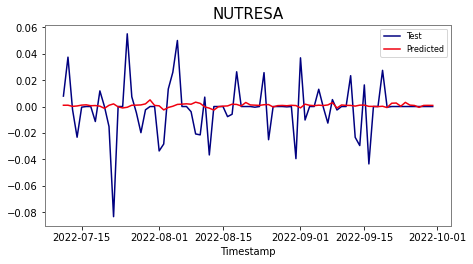

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:49:32         1399
metadata.json                                  2023-03-30 07:49:32           64
variables.h5                                   2023-03-30 07:49:32        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
75.19522184036764
0.015095197140772511
0.023308896582440883
1/1 [==============================] - 0s 24ms/step
Imprimir grafico train-test


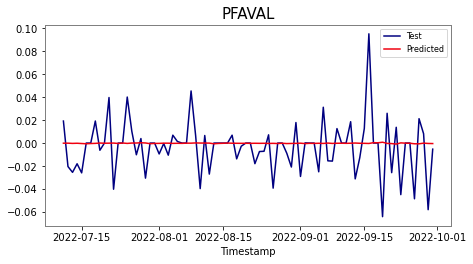

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:50:00         1399
metadata.json                                  2023-03-30 07:50:00           64
variables.h5                                   2023-03-30 07:50:00        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
51.34178870019225
0.01290481610226152
0.023073340327068828
1/1 [==============================] - 0s 25ms/step
Imprimir grafico train-test


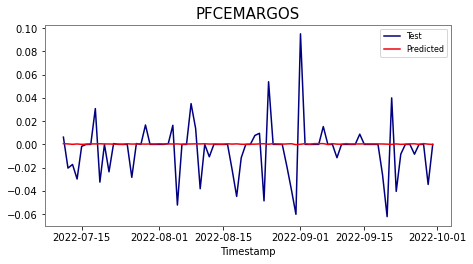

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:50:16         1399
metadata.json                                  2023-03-30 07:50:16           64
variables.h5                                   2023-03-30 07:50:16        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
49.98945120744244
0.009897363977159828
0.017898488252674077
1/1 [==============================] - 0s 22ms/step
Imprimir grafico train-test


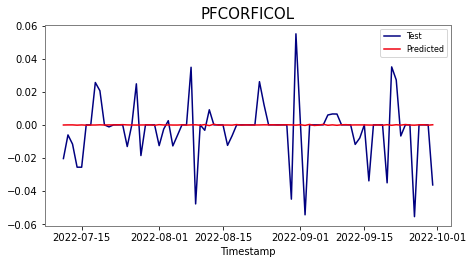

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:50:32         1399
metadata.json                                  2023-03-30 07:50:32           64
variables.h5                                   2023-03-30 07:50:32        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
82.73074947227627
0.01028529529877057
0.016891706632231964
1/1 [==============================] - 0s 24ms/step
Imprimir grafico train-test


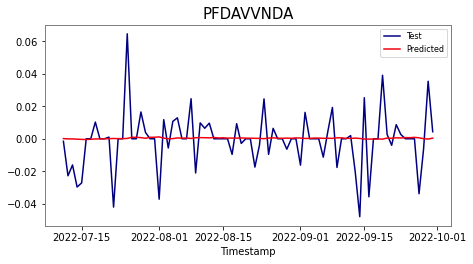

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:50:52         1399
metadata.json                                  2023-03-30 07:50:52           64
variables.h5                                   2023-03-30 07:50:52        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
74.24140249150656
0.015489467518743008
0.02529598830116787
1/1 [==============================] - 0s 23ms/step
Imprimir grafico train-test


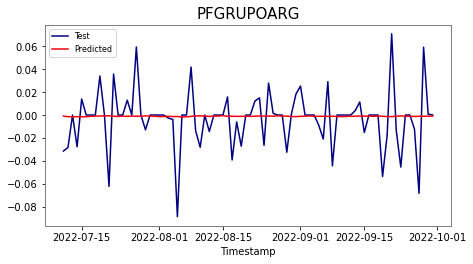

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 07:51:58         1399
metadata.json                                  2023-03-30 07:51:58           64
variables.h5                                   2023-03-30 07:51:58        19424
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
cargando los datos
(733, 2)
(1095, 1)
32/32 [==============================] - 0s 1ms/step
79.21871305714974
0.013168184100562612
0.022843565810926558
1/1 [==============================] - 0s 27ms/step
Imprimir grafico train-test


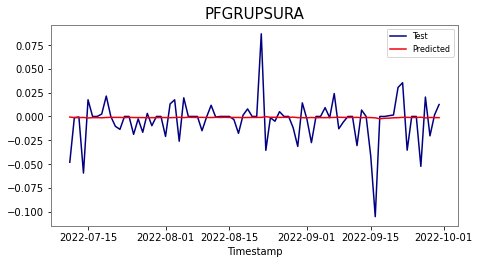

In [60]:
for j in Accion:

    path_model='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/modelos/' + j + '_model_rn.pkl'
    with open(path_model, 'rb') as archivo:
        model= pickle.load(archivo)
        
    print('cargando los datos')
        
    info = data_series[(data_series['nemotecnico']==j)]
    tabla=info.copy()
    serie = tabla[['fecha','nemotecnico','variacion_log']]
    del tabla, info
    #serie=data_series[(data_series['nemotecnico']==Accion)]
    serie.set_index('fecha',inplace=True)
    print(serie.shape)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    idx_ = pd.date_range(serie.index.min(), serie.index.max() + np.timedelta64(dias_predecir,'D'))
    serie=serie.reindex(idx, fill_value=0)
    serie.reset_index(inplace=True)
    serie.rename(columns={'index':'fecha'},inplace=True)
    serie.drop(columns=['nemotecnico'],inplace=True)
    serie.set_index('fecha',inplace=True)
    print(serie.shape)

    values = serie['variacion_log'].values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) 
    scaled = scaler.fit_transform(values)
    reframed = serie_supervisada(scaled, Input_features, 1)  
    #train_size=len(reframed)*0.8
    train_size=1003
    values = reframed.values
    train,test  = values[:int(train_size), :],values[int(train_size):, :]
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    
    testPredict = model.predict(x_test)
    testPredict=[a[0][0] for a in testPredict]
    testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
    trainPredict = model.predict(x_train)
    trainPredict=[a[0][0] for a in trainPredict]
    trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])
    serie.reset_index(inplace=True)

    predicciones_train=pd.DataFrame(trainPredict[0])
    valores_train=pd.DataFrame(y_train[0])
    predicciones_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
    valores_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
    
    predicciones_test=pd.DataFrame(testPredict[0])
    valores_test=pd.DataFrame(y_test[0])
    predicciones_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    valores_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    error_mape = mean_absolute_percentage_error(valores_test, predicciones_test)
    print(error_mape)
    error = mean_absolute_error(valores_test, predicciones_test) 
    print(error)
    error_rmse = rmse_rn(valores_test, predicciones_test)
    print(error_rmse[0])

    results=[]
    incio=x_test[-1:]
    for i in range(dias_predecir):
        parcial=model.predict(incio)
        parcial_=scaler.inverse_transform(parcial[0])
        results.append(parcial_[0][0])
        incio=agregarNuevoValor(incio,parcial[0])
    result=pd.DataFrame(results)[0]

    predicciones=pd.DataFrame(result)
    predicciones.rename(columns={0:variable_inte},inplace=True)
    
    print('Imprimir grafico train-test')

    plt.figure(figsize=(7.28, 3.7 ))
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,serie['variacion_log'][-82:],color='#000080', label='Serie Original')
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],color = '#F0000F', label='Predicción Test')
    #plt.plot(idx_[Input_features:len(x_train)+Input_features].values,trainPredict[0],c='y', label='Predicción Train')
    #plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
    plt.xticks(rotation=0)
    plt.legend(['Test','Predicted'],loc=0, fontsize = 8)
    plt.title('Resultados del Modelo', fontsize=15)
    plt.title(str(j), fontsize=15)
    plt.xlabel('Timestamp')
    plt.savefig(path_grafico + 'grafico_comparacion_test_train_rn_'+str(j)+'.jpg',facecolor='white')
    plt.show()

